In [2]:
import glob
import json
import os
import pickle
import random
import traceback
from typing import Tuple

import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Lambda, LeakyReLU, AveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from matplotlib.pyplot import hist
from PIL import Image
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
import csv
import time

## Config & Constants

In [4]:
IMAGE_WIDTH, IMAGE_HEIGHT = 227, 227
random.seed(52)

## Methods

### Image Utilities

In [5]:
def batch_generator(input_data, output_data, batch_size, is_training):
    input_data_batch = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 1])
    output_data_batch = np.empty([batch_size, 1])
    while True:
        index = 0
        for i in np.random.permutation(input_data.shape[0]):
            input_data_batch[index] = input_data[i]
            output_data_batch[index] = output_data[i]
            index += 1
            if index == batch_size:
                break
        yield input_data_batch, output_data_batch


def _preprocess(image_loc: str) -> np.ndarray:
    f_image = Image.open(image_loc).convert('L')
    f_image = f_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.ANTIALIAS)
    image = np.asarray(f_image)
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=3)
    return image


def preprocess(loc: str) -> np.ndarray:
    """Safety wrapper over _preprocess.
    
    Args:
        loc: File location to check if dir or an image.
        
    Returns:
        Preprocessed image(s) as an ndarray.
    """
    if os.path.isdir(loc):
        current = np.concatenate((
            [_preprocess(os.path.join(loc, image)) for image in os.listdir(loc)
             if '.png' in image]
        ))
    else:
        current = _preprocess(loc)
    return current


def generate_data_arrays(
    covid_data: str = 'rsc/New_Data_CoV2/COVID/',
    noncovid_data: str = 'rsc/New_Data_CoV2/non-COVID/',
    others_data:  str = 'rsc/New_Data_CoV2/Others/',
    image_output: str = 'rsc/input_data_v2',
    label_output: str = 'rsc/output_data_v2',
    regenerate: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """Loads COVID images into ndarrays.
    
    Args:
        covid_data: Relative path to folder containing COVID images.
        noncovid_data: Relative path to folder containing non-COVID images.
        others_data: Relative path to folder containing Others images.
        image_output: Relative path (with filename) to save loaded images to.
        label_output: Relative path (with filename) to save loaded classes (labels) to.
        regenerate: If True, will regenerate saved ndarray files for both image_output
            and label_output, even if they already exist (overwriting them). If False,
            will simply load and return the aforementioned.
        
    Returns:
        Tuple of ndarrays. The first is the loaded image data in one large ndarray,
        and the second is the loaded labels, also in a large ndarray. These directly
        match up to each other ONLY when both arrays (and their respective files)
        are generated at the same time with this method.
    """
    if (regenerate is False and 
        os.path.isfile(f'{out_input_data}.npy') and
        os.path.isfile(f'{out_output_data}.npy')):
        return (np.load(f'{out_input_data}.npy'),
                np.load(f'{out_output_data}.npy'))
    
    if not ((cd := os.path.exists(covid_data)) and (ncd := os.path.exists(noncovid_data))):
        if (others_data is not None) and not (odd := os.path.exists(others_data)):
            raise NotADirectoryError("Directories do not exist.")
        else:
            raise NotADirectoryError("COVID/non-COVID directories do not exist.")
    
    im_data = np.empty([1, IMAGE_WIDTH, IMAGE_WIDTH, 1])
    output = np.array([0])

    print('Loading Covid Data')
    for i in tqdm(glob.glob(os.path.join(covid_data, '**'))):
        current = preprocess(i)
        im_data = np.concatenate((im_data, current))
        output = np.concatenate((output, np.array([1])), axis=0)

    print('Loading non-Covid Data')
    for i in tqdm(glob.glob(os.path.join(noncovid_data, '**'))):
        current = preprocess(i)
        im_data = np.concatenate((im_data, current))
        output = np.concatenate((output, np.array([0])), axis=0)
        
    if others_data is not None:
        print('Loading Others Data')
        for i in tqdm(glob.glob(os.path.join(others_data, '**'))):
            current = preprocess(i)
            im_data = np.concatenate((im_data, current))
            output = np.concatenate((output, np.array([-1])), axis=0)
    else:
        print('Others data not provided; skipping.')


    print('Finished Loading Data')
    im_data = np.delete(im_data, 0, axis=0)
    output = np.delete(output, 0, axis=0)

    zip_data = list(zip(im_data, output))
    random.shuffle(zip_data)
    im_data, output = zip(*zip_data)

    np.save(f'{image_output}', im_data)
    np.save(f'{label_output}', output)
    return im_data, output


def load_data(image_loc: str, label_loc: str, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
    """Attempts to load generated images and labels.
    
    If either is not found, attempts to (re)generate them using the default
    input arguments to the generation method for the raw data, but the input
    `image_loc` and `label_loc` parameters for the output arrays. If this
    still does not work, returns a general error and exits.
    
    Args:
        image_loc: Relative path to saved image ndarray file.
        label_loc: Relative path to saved label ndarray file.
        
    Returns:
        Tuple of ndarrays. The first array holds the loaded image data, whilst
        the second array holds their respective labels.
    
    """
    try:
        image_data = np.load(f'{image_loc}.npy')
        label_data = np.load(f'{label_loc}.npy')
        return image_data, label_data
    
    except FileNotFoundError:
        try:
            image_data, label_data = generate_data_arrays(
                image_output = image_loc,
                label_output = label_loc,
                **kwargs
            )
            return image_data, label_data
        
        except Exception as e:
            traceback.print_exc()

## Model Playground

In [8]:
#Version 1
im_data_v1, output_v1 = load_data(
    image_loc = 'rsc/input_data_v1',
    label_loc = 'rsc/output_data_v1',
    covid_data = 'rsc/Data_CoV2/COVID/',
    noncovid_data = 'rsc/Data_CoV2/non-COVID/',
    others_data = None,
)

x_train, x_test, y_train, y_test = train_test_split(im_data_v1, output_v1, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [2481, 4171]

In [9]:
print(y_train)

NameError: name 'y_train' is not defined

In [14]:
def make_model(X_Train, Y_Train, X_Test, Y_Test, model_dir: str):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    #X_Train, X_Test, Y_Train, Y_Test = train_test_split(input_data, output_data, test_size=0.1)

    for_pad = lambda s: s if s > 2 else 3

    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)))

    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=8, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=16, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=32, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    #model.add(ZeroPadding2D(padding=(for_pad(1) - 1)//2))
    model.add(Conv2D(kernel_size=(1, 1), filters=16, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=32, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=64, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    #model.add(ZeroPadding2D(padding=(for_pad(1) - 1)//2))
    model.add(Conv2D(kernel_size=(1, 1), filters=32, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=64, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))


    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=128, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    #model.add(ZeroPadding2D(padding=(for_pad(1) - 1)//2))
    model.add(Conv2D(kernel_size=(1, 1), filters=64, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=128, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))


    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=256, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    #model.add(ZeroPadding2D(padding=(for_pad(1) - 1)//2))
    model.add(Conv2D(kernel_size=(1, 1), filters=128, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    #model.add(ZeroPadding2D(padding=(for_pad(3) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=256, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    #model.add(ZeroPadding2D(padding=(for_pad(1) - 1)//2))
    model.add(Conv2D(kernel_size=(1, 1), filters=128, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))



    #model.add(ZeroPadding2D(padding=(for_pad(19) - 1)//2))
    model.add(Conv2D(kernel_size=(3, 3), filters=256, strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    #model.add(Conv2D(kernel_size=(3, 3), filters=2, strides=(1, 1),activation='relu'))

    model.add(Flatten())

    model.add(Dropout(rate=0.4))
    model.add(Dense(units=338, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adamax(lr = 3e-4), loss='binary_crossentropy', metrics=["accuracy"])
    model.summary()

    checkpoint = ModelCheckpoint(os.path.join(model_dir, 'xRGM2.4'), verbose=1, period=1, save_best_only=True)

    hist = model.fit(batch_generator(X_Train, Y_Train, 128, True),
                        validation_data=(batch_generator(X_Test, Y_Test, 128, False)), callbacks=[checkpoint],
                        verbose=1, epochs=75, steps_per_epoch=25, validation_steps=len(X_Test))

    with open(os.path.join('models', 'xRGM2.4-Net-HistDict'), 'wb') as f:
        pickle.dump(hist.history, f)

    model.save(model_dir)
    
    return model
#lr = 3e-4

In [15]:
%%time
model_dir: str = 'model/xRGM2.4'
xRGM = make_model(x_train, y_train.reshape(-1,1), x_test, y_test.reshape(-1,1), model_dir=model_dir)

v_classify = np.vectorize(lambda x: np.round(x, 0))
# xRGMCT2 = load_model('models/xRGMCT2L.h5')
# print(xRGMCT2.history)
y_pred = (xRGM.predict(x_test))

#print(y_test)
#print(y_pred)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 227, 227, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 225, 225, 8)       80        
_________________________________________________________________
batch_normalization_16 (Batc (None, 225, 225, 8)       32        
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 225, 225, 8)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 110, 110, 16)      1168      
_________________________________________________________________
batch_normalization_17 (Batc (None, 110, 110, 16)     

INFO:tensorflow:Assets written to: model/xRGM2.4/xRGM2.4/assets
Epoch 2/75
25/25 [==============================] - 1865s 77s/step - loss: 0.3563 - accuracy: 0.8445 - val_loss: 0.6946 - val_accuracy: 0.5002

Epoch 00002: val_loss improved from 0.69529 to 0.69464, saving model to model/xRGM2.4/xRGM2.4
INFO:tensorflow:Assets written to: model/xRGM2.4/xRGM2.4/assets
Epoch 3/75
25/25 [==============================] - 1795s 74s/step - loss: 0.1963 - accuracy: 0.9178 - val_loss: 0.6886 - val_accuracy: 0.5161

Epoch 00003: val_loss improved from 0.69464 to 0.68858, saving model to model/xRGM2.4/xRGM2.4
INFO:tensorflow:Assets written to: model/xRGM2.4/xRGM2.4/assets
Epoch 4/75
25/25 [==============================] - 1794s 74s/step - loss: 0.1450 - accuracy: 0.9508 - val_loss: 0.6852 - val_accuracy: 0.5006

Epoch 00004: val_loss improved from 0.68858 to 0.68521, saving model to model/xRGM2.4/xRGM2.4
INFO:tensorflow:Assets written to: model/xRGM2.4/xRGM2.4/assets
Epoch 5/75
25/25 [============

25/25 [==============================] - 7966s 330s/step - loss: 7.7669e-04 - accuracy: 0.9999 - val_loss: 0.1171 - val_accuracy: 0.9563

Epoch 00034: val_loss did not improve from 0.09228
Epoch 35/75
25/25 [==============================] - 7952s 329s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1153 - val_accuracy: 0.9605

Epoch 00035: val_loss did not improve from 0.09228
Epoch 36/75
25/25 [==============================] - 7952s 329s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1031 - val_accuracy: 0.9631

Epoch 00036: val_loss did not improve from 0.09228
Epoch 37/75
25/25 [==============================] - 7969s 330s/step - loss: 6.8928e-04 - accuracy: 1.0000 - val_loss: 0.1035 - val_accuracy: 0.9625

Epoch 00037: val_loss did not improve from 0.09228
Epoch 38/75
25/25 [==============================] - 9379s 389s/step - loss: 5.3952e-04 - accuracy: 1.0000 - val_loss: 0.1048 - val_accuracy: 0.9640

Epoch 00038: val_loss did not improve from 0.09228
Epoch 39/75
25/

25/25 [==============================] - 9654s 399s/step - loss: 7.8196e-05 - accuracy: 1.0000 - val_loss: 0.1206 - val_accuracy: 0.9593

Epoch 00075: val_loss did not improve from 0.09228
INFO:tensorflow:Assets written to: model/xRGM2.4/assets
CPU times: user 21d 9h 57min 15s, sys: 17h 41s, total: 22d 2h 57min 56s
Wall time: 6d 1h 26min 14s


In [16]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, v_classify(y_pred)),
                                columns=['Predicted Negative', 'Predicted Positive'],
                                index=['Actual Negative', 'Actual Positive'])

tp, tn, fp, fn = (
    confusion_matrix.iloc[1,1], 
    confusion_matrix.iloc[0,0], 
    confusion_matrix.iloc[0,1], 
    confusion_matrix.iloc[1,0]
)

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * ((specificity * sensitivity) / (specificity + sensitivity))

with open(os.path.join(f'{model_dir}', 'metrics.csv'), 'a', encoding='utf-8') as f:
    f.write(
        f'{time.strftime("%Y-%m-%dT%H:%M:%S-05:00", time.localtime())}, {accuracy}, {sensitivity}, {specificity}, {f1_score}\n'
    )

print(f'Accuracy:    {accuracy}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')
print(f'F1 Score:    {f1_score}')
print('\n')
print(confusion_matrix)


Accuracy:    0.9581320450885669
Sensitivity: 0.9419354838709677
Specificity: 0.9742765273311897
F1 Score:    0.9578330861417544


                 Predicted Negative  Predicted Positive
Actual Negative                 303                   8
Actual Positive                  18                 292


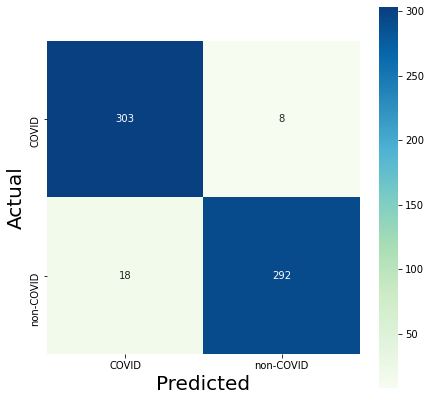

In [17]:
disease_types=['COVID', 'non-COVID']
Y_pred = np.argmax(y_pred)
Y_true = np.argmax(y_test)

plt.figure(figsize=(7, 7))
ax = sns.heatmap(confusion_matrix , cmap=plt.cm.GnBu , 
                 annot=True, fmt='d',square=True, xticklabels=disease_types, 
                 yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()


In [18]:
def plot_model_history(model_history):
   fig, axs = plt.subplots(1,2,figsize=(15,5))
   # summarize history for accuracy
   axs[0].plot(range(1, len(model_history['accuracy']) + 1), model_history['accuracy'])
   axs[0].plot(range(1, len(model_history['val_accuracy']) + 1), model_history['val_accuracy'])
   axs[0].set_title('Model Accuracy')
   axs[0].set_ylabel('Accuracy')
   axs[0].set_xlabel('Epoch')
   axs[0].set_xticks(np.arange(1, len(model_history['accuracy']) + 1), len(model_history['accuracy']) / 10)
   axs[0].legend(['train', 'val'], loc='best')
   # summarize history for loss
   axs[1].plot(range(1, len(model_history['loss'])+1), model_history['loss'])
   axs[1].plot(range(1, len(model_history['val_loss']) + 1), model_history['val_loss'])
   axs[1].set_title('Model Loss')
   axs[1].set_ylabel('Loss')
   axs[1].set_xlabel('Epoch')
   axs[1].set_xticks(np.arange(1, len(model_history['loss']) + 1), len(model_history['loss']) / 10)
   axs[1].legend(['train', 'val'], loc='best')
   plt.show()


<ipython-input-18-25025fac5012>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history['accuracy']) + 1), len(model_history['accuracy']) / 10)
<ipython-input-18-25025fac5012>:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history['loss']) + 1), len(model_history['loss']) / 10)


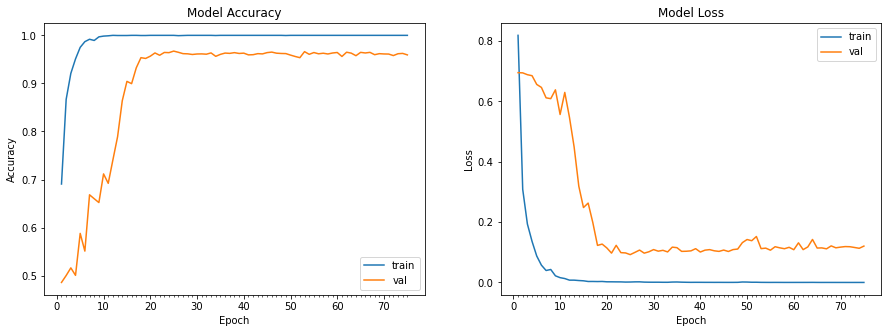

In [19]:
with open(os.path.join('models', 'xRGM2.4-Net-HistDict'), 'rb') as f:
    history = pickle.load(f)
    
plot_model_history(history)